In [1]:
# Imports
import os
import shutil
import requests
import uuid
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from huggingface_hub import hf_hub_download, list_repo_files
from flyt.factory import MixingModel, create_scoring_model
from open_clip.src.open_clip import create_model

# Load a model

In [2]:
models_repo_id = 'formll/FLYT-models'
cache_dir = None  # Specify cache dir if you want

In [3]:
# load FLYT checkpoint
flyt_filename = 'scoring_models/flyt.pt'
flyt_model_path = hf_hub_download(
    repo_id=models_repo_id,
    filename=flyt_filename,
    cache_dir=cache_dir)
flyt_checkpoint = torch.load(flyt_model_path, map_location='cpu', weights_only=True)
# Load weights to model
scoring_model = create_scoring_model(
    model_name='ViT-B-32',
    full_scoring_pretrained=flyt_model_path)
# Look at the code to see the different parameters. For this model the parameters receive mostly default values.

In [4]:
# load M-FLYT checkpoint
mflyt_filename = 'scoring_models/mflyt.pt'
mflyt_model_path = hf_hub_download(
    repo_id=models_repo_id,
    filename=mflyt_filename,
    cache_dir=cache_dir)
mflyt_checkpoint = torch.load(mflyt_model_path, map_location='cpu', weights_only=True)
# Load weights to model
num_scores = mflyt_checkpoint['layers.0.weight'].shape[1]
mixing_model = MixingModel(num_scores=num_scores)
mixing_model.load_state_dict(mflyt_checkpoint)

<All keys matched successfully>

In [5]:
# Load CLIP checkpoint
clip_filename = 'medium/mflyt_medium_scs015/model.pt'
clip_model_path = hf_hub_download(
    repo_id=models_repo_id,
    filename=clip_filename,
    cache_dir=cache_dir)
clip_model = create_model(
    model_name='ViT-B-32',
    pretrained=clip_model_path)

## Example: view M-FLYT linear weights (Table 2)

In [6]:
linear_weights = mixing_model.layers[0].weight.detach().numpy()[0].tolist()
input_scores_names = [
    "vit-b-32", "vit-l-14",
    "DFN-Base", "DFN-FT",
    "CC2M-Classifier", "IN1K-Classifier",
    "FLYT",
    "normsim_inf", "negCLIPLoss", 
    "hype_lorentzian_distance", "hype_image_specificity", "hype_text_specificity"]

In [7]:
max_n_len = max(len(n) for n in input_scores_names)
print(f"{'Model Name'.ljust(max_n_len + 5)}Weight\n")

for n, w in zip(input_scores_names, linear_weights):
    w_str = f"{w:.2f}"
    print(f"{n.ljust(max_n_len + 5)}{w_str}")

Model Name                   Weight

vit-b-32                     0.08
vit-l-14                     0.21
DFN-Base                     0.60
DFN-FT                       0.80
CC2M-Classifier              0.17
IN1K-Classifier              0.36
FLYT                         0.65
normsim_inf                  0.55
negCLIPLoss                  0.51
hype_lorentzian_distance     0.45
hype_image_specificity       -0.05
hype_text_specificity        0.02


# Download parquet scores for training
Download the dataset from Hugging face and save it in the format the training code expects.

In [8]:
def download_parquet_dataset_from_hf(repo_id, tmp_dir="tmp_dir"):
    """Download parquet files from Hugging Face and load them into a single dataframe"""
    os.makedirs(tmp_dir, exist_ok=False)  # The directory will be deleted at the end of this function
    files = list_repo_files(repo_id, repo_type="dataset")
    parquet_files = [f for f in files if f.endswith('.parquet')]
    dfs = []
    
    try:
        for f in tqdm(parquet_files):
            file_path = hf_hub_download(repo_id=repo_id, filename=f, cache_dir=tmp_dir, repo_type="dataset")
            df = pd.read_parquet(file_path)
            dfs.append(df)
        
        combined_df = pd.concat(dfs, ignore_index=True)

        return combined_df
    
    finally:
        shutil.rmtree(tmp_dir)

def save_to_parquet_chunks(df, output_dir, prefix_length=8):
    """Save a dataframe to parquet files in the format {00000000..XXXXXXXX}_scores.parquet"""
    os.makedirs(output_dir, exist_ok=True)
    df['key_prefix'] = df['key'].str[:prefix_length]
    
    for prefix, group in tqdm(df.groupby('key_prefix')):
        group = group.drop('key_prefix', axis=1)
        output_file = os.path.join(output_dir, f"{prefix}_scores.parquet")
        group.to_parquet(output_file, index=False)

In [9]:
scores_repo_id = "formll/M-FLYT-input-scores"
output_dir="parquet_data"  # Output directory for the parquet files.
tmp_dir="tmp_dir"  # Temporary directory path that will be deleted after loading the dataset

df = download_parquet_dataset_from_hf(repo_id=scores_repo_id, tmp_dir=tmp_dir)
save_to_parquet_chunks(df, output_dir)

  0%|          | 0/37 [00:00<?, ?it/s]

train-00000-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00001-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00002-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00003-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00004-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00005-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00006-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00007-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00008-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00009-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00010-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00011-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00012-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00013-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00014-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00015-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00016-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00017-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00018-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00019-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00020-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00021-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00022-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00023-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00024-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00025-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00026-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00027-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00028-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00029-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00030-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00031-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00032-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00033-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00034-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00035-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

train-00036-of-00037.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

  0%|          | 0/12896 [00:00<?, ?it/s]

# Soft Cap Sampling and Hard Cap Sampling

In [10]:
# Generate a dummy dataframe of random "uids" and scores to demonstrate SCS and HCS.
# In practice, you should run a scoring model on the DataComp dataset to create a dataframe of real UIDs and scores.

def generate_random_df(num_rows=128_000):
    # Generate random UIDs 
    uids = []
    for _ in range(num_rows):
        random_hex = uuid.uuid4().hex
        while len(random_hex) < 32:
            random_hex = "0" + random_hex
        uids.append(random_hex)
    
    # Generate Gaussian distributed scores
    scores = np.random.normal(loc=0.0, scale=2.5, size=num_rows)
    
    df = pd.DataFrame({'uid': uids, 'score': scores})
    
    return df

scores_df = generate_random_df()

In [11]:
scores_df.iloc[:5]

,uid,score
0,12cd4571ed274b20bc7eaaefeb4dfd13,-0.715107
1,649cb87f0005407a9fb1742643d0e765,-0.850894
2,eeaf697451754d6191bb1c08bece19ab,-0.475887
3,d42a2b88edda4d72b5c7e83f70c14451,0.351007
4,aac8cdbd8d8148d78a73ff996620fc50,-2.741925


<Axes: >

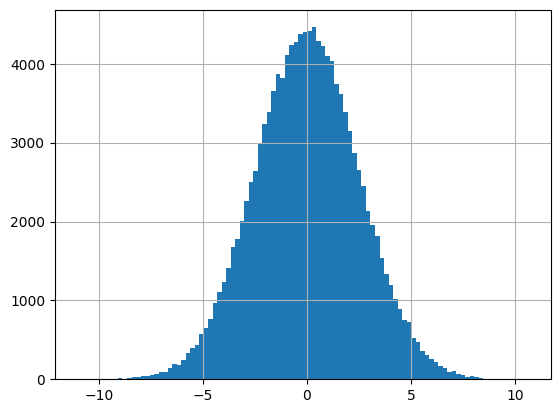

In [12]:
scores_df['score'].hist(bins=100)

In [13]:
from scipy.special import softmax
def convert_base16_str_to_2_nums(uids):
    """Converts uids in string format to dtype=[('f0', '<u8'), ('f1', '<u8')] that is used by the DataComp resharder"""
    return np.array(
        [(int(uid[:16], 16), int(uid[16:32], 16)) for uid in uids], np.dtype("u8,u8"))

def soft_cap_sampling(df, repetition_penalty, total_size=128_000_000, scores_col='score', batch_size=100_000):
    pre_softmax = df[scores_col].values.copy()
    
    indices = df.index
    sampled_indices = []

    with tqdm(total=total_size, desc="Sampling") as pbar:
        while len(sampled_indices) < total_size:
            probs = softmax(pre_softmax)
            
            # Sample batch
            batch_size = min(batch_size, total_size - len(sampled_indices))
            batch = np.random.choice(indices, size=batch_size, p=probs, replace=False)
    
            sampled_indices = np.concatenate([sampled_indices, batch])
            pre_softmax[batch] -= repetition_penalty
            pbar.update(batch_size)
            
    return np.array(sampled_indices)

In [14]:
scs_sampled_indices = soft_cap_sampling(scores_df, repetition_penalty=0.15, total_size=128_000, batch_size=100)

Sampling:   0%|          | 0/128000 [00:00<?, ?it/s]

In [15]:
scs_uids = convert_base16_str_to_2_nums(scores_df.loc[scs_sampled_indices, 'uid'].values)
scs_uids.sort()

In [16]:
pd.value_counts(scs_uids)

(3255344698199460802, 9632619211100621694)      44
(13374296148208140656, 10578773258685140480)    44
(9336541739983850336, 11828794221445939517)     41
(11389620096099500426, 11216317604645705849)    41
(2035832706695711260, 10785756619996908161)     40
                                                ..
(8563996129610451167, 9374702557412214994)       1
(8563238695888308773, 12957748429224105458)      1
(8559147052888377974, 13048377904476344586)      1
(8558741260083676598, 13211173076444703784)      1
(18446528657643752204, 10446305510704443053)     1
Name: count, Length: 37487, dtype: int64

In [17]:
def hard_cap_sampling(df, frequency_limit, total_size=128_000_000, scores_col='score', batch_size=1_000_000):
    probs = softmax(df[scores_col].values)
    indices = df.index
    counts = np.zeros_like(indices)
    sampled_indices = []

    with tqdm(total=total_size, desc="Sampling") as pbar:
        while len(sampled_indices) < total_size:
            # Create mask for valid indices (count < max_repeats)
            valid_mask = counts < frequency_limit
            
            # Zero out probabilities for invalid indices and renormalize
            masked_probs = probs * valid_mask
            masked_probs = masked_probs / masked_probs.sum()
            
            # Sample batch
            batch_size = min(batch_size, total_size - len(sampled_indices))
            batch = np.random.choice(indices, size=batch_size, p=masked_probs, replace=True)
            
            # Update counts and collect sampled_indices
            for idx in batch:
                if len(sampled_indices) >= total_size:
                    break
                
                if counts[idx] < frequency_limit:
                    sampled_indices.append(idx)
                    counts[idx] = counts[idx] + 1
                    
            pbar.update(batch_size)

    return np.array(sampled_indices)

In [18]:
hcs_sampled_indices = hard_cap_sampling(scores_df, frequency_limit=15, total_size=128_000, batch_size=100)

Sampling:   0%|          | 0/128000 [00:00<?, ?it/s]

In [19]:
hcs_uids = convert_base16_str_to_2_nums(scores_df.loc[hcs_sampled_indices, 'uid'].values)
hcs_uids.sort()

In [20]:
pd.value_counts(hcs_uids)

(3078583787178510497, 11764786742603000304)     15
(8020123843118844922, 9463100297232035801)      15
(9716936960599736467, 9569276147193349359)      15
(10712521234469307738, 11210997836750414383)    15
(9717429857683261873, 9503729397272228282)      15
                                                ..
(5636012089858149659, 13266799088291232785)      1
(12296844948496403098, 10703922408933454170)     1
(5634809896747224026, 9780353871664001926)       1
(12297010276001333750, 9817652693989342663)      1
(66670897807644, 13120469940474069220)           1
Name: count, Length: 33191, dtype: int64

# Load M-FLYT input scores models

In [21]:
input_scores_models_repo_id = "formll/M-FLYT-input-scores-models"
cache_dir = None  # Specify cache dir if you want

In [22]:
classifier_filename = 'CC2M-Classifier.pt'  # Same for 'IN1K-Classifier.pt'
classifier_model_path = hf_hub_download(
    repo_id=input_scores_models_repo_id,
    filename=classifier_filename,
    cache_dir=cache_dir)
classifier_checkpoint = torch.load(classifier_model_path, map_location='cpu', weights_only=True)

In [23]:
classifier = torch.nn.Linear(classifier_checkpoint['weight'].shape[1], classifier_checkpoint['weight'].shape[0])
classifier.load_state_dict(classifier_checkpoint)

<All keys matched successfully>

In [24]:
dfn_filename = 'DFN-FT.pt'  # Same for 'DFN-Base.pt'
dfn_model_path = hf_hub_download(
    repo_id=input_scores_models_repo_id,
    filename=dfn_filename,
    cache_dir=cache_dir)
dfn_model = create_model(
    model_name='ViT-B-32',
    pretrained=dfn_model_path)